In [339]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [338]:
import torch                                        # root package
from torch.utils.data import Dataset, DataLoader    # dataset representation and loading

import numpy as np
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torchvision import datasets, transforms
from time import time
import os
import tempfile
import optuna
from optuna.trial import TrialState
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    MaskIntensity,
    ThresholdIntensity
)
from monai.utils import set_determinism
from monai.transforms.utils import rescale_array
import PIL
import matplotlib.pyplot as plt
import math
import random

from custommodels import AutoEnc
from customfunctions import resetSeeds,splitData,loadMedNISTData,loadDSprites

import seaborn as sns
sns.set(rc={'figure.figsize':(5,5)})

In [277]:
resetSeeds() #helps when rerunning cells

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"Created temp directory {root_dir}.")

Created temp directory C:\Users\irose\AppData\Local\Temp\tmplw8iz7gu.


c:\Users\irose\miniconda3\envs\mriproj\lib\site-packages\monai\apps\utils.py:110: UserWarning: tqdm is not installed, will not show the downloading progress bar.
  warnings.warn("tqdm is not installed, will not show the downloading progress bar.")


2022-11-22 03:24:27,427 - INFO - Downloaded: C:\Users\irose\AppData\Local\Temp\tmplw8iz7gu\MedNIST.tar.gz
2022-11-22 03:24:27,517 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-11-22 03:24:27,519 - INFO - Writing into directory: C:\Users\irose\AppData\Local\Temp\tmplw8iz7gu.


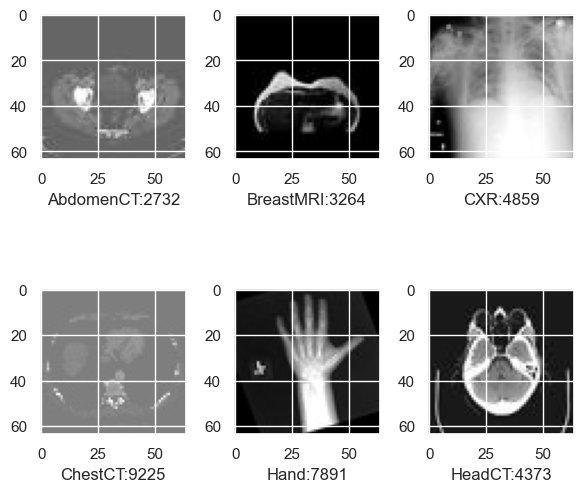

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: {'AbdomenCT': 10000, 'BreastMRI': 8954, 'CXR': 10000, 'ChestCT': 10000, 'Hand': 10000, 'HeadCT': 10000}
Keys: <KeysViewHDF5 ['imgs', 'latents']>
Number of frames: 737280
For HeadCT added 6000 train, 2000 val, 2000 test.
Val has 600/2000 sprited images, Test has 600/2000 sprited images, 


In [278]:
train_file_name = "MedNIST_train.npy"
val_file_name = "MedNIST_val.npy"
test_file_name = "MedNIST_test.npy"
folder="MedNIST_data"
if not os.path.exists(os.path.join(folder,train_file_name)) and not os.path.exists(os.path.join(folder,val_file_name)) and not os.path.exists(os.path.join(folder,test_file_name)):
    if not os.path.exists(folder):
        os.mkdir(folder)
    image_files = loadMedNISTData(root_dir)
    mask_imgs = loadDSprites()
    train_x,val_x,test_x  = splitData((.6,.2,.2),image_files,mask_imgs)
    np.save(os.path.join(folder,train_file_name),train_x)
    np.save(os.path.join(folder,val_file_name),val_x)
    np.save(os.path.join(folder,test_file_name),test_x)
else:
    with open(os.path.join(folder,train_file_name), 'rb') as f:
        train_x = np.load(f)
    with open(os.path.join(folder,val_file_name), 'rb') as f:
        val_x = np.load(f)
    with open(os.path.join(folder,test_file_name), 'rb') as f:
        test_x = np.load(f)
    print(f"Loaded files from {folder}.")
    print(f"Loaded {len(train_x)} train, {len(val_x)} val, {len(test_x)} test.")

In [279]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files):
        self.image_files = image_files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.image_files[index][0],self.image_files[index][1]


train_ds = MedNISTDataset(train_x)
train_loader = DataLoader(train_ds, batch_size=256,shuffle=True) #already should be shuffled in the data loaded in but why not

val_ds = MedNISTDataset(val_x)
val_loader = DataLoader(val_ds, batch_size=256)

test_ds = MedNISTDataset(test_x)
test_loader = DataLoader(test_ds, batch_size=256)

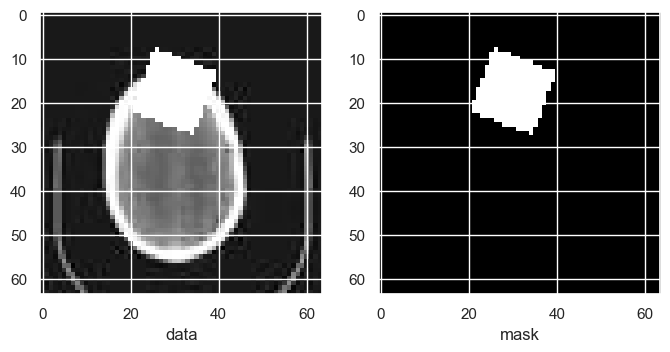

In [280]:
plt.subplots(1,3, figsize=(8, 8))

plt.subplot(1,2,1)
plt.xlabel(f"data")
plt.imshow(val_ds[101][0][0], cmap="gray", vmin=0, vmax=1)

plt.subplot(1,2,2)
plt.xlabel(f"mask")
plt.imshow(val_ds[101][1][0], cmap="gray", vmin=0, vmax=1)
plt.show()


In [319]:
#taken from the brainweb github code
#plan on cleaning this up because it is messy

def compute_dice_curve_recursive(predictions, labels, filename=None, plottitle="DICE Curve", granularity=5):
    scores, threshs = compute_dice_score(predictions, labels, granularity)

    best_score, best_threshold = sorted(zip(scores, threshs), reverse=True)[0]

    min_threshs, max_threshs = min(threshs), max(threshs)
    buffer_range = math.fabs(min_threshs - max_threshs) * 0.02
    x_min, x_max = min(threshs) - buffer_range, max(threshs) + buffer_range
    fig = plt.figure()
    plt.plot(threshs, scores, color='darkorange', lw=2, label='DICE vs Threshold Curve')
    plt.xlim([x_min, x_max])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Thresholds')
    plt.ylabel('DICE Score')
    plt.title(plottitle)
    plt.legend(loc="lower right")
    plt.text(x_max - x_max * 0.01, 1, f'Best dice score at {best_threshold:.5f} with {best_score:.4f}', horizontalalignment='right',
                           verticalalignment='top')
    #plt.show()

    # save a pdf to disk
    if filename:
        fig.savefig(filename)

        with open(filename + ".csv", mode="w") as csv_file:
            fieldnames = ["Thresholds", "DICE Score"]
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
            writer.writeheader()
            for i in range(len(scores)):
                writer.writerow({fieldnames[0]: threshs[i], fieldnames[1]: scores[i]})
    plt.close(fig)

    bestthresh_idx = np.argmax(scores)
    return scores[bestthresh_idx], threshs[bestthresh_idx]

def dice(P, G):
    psum = np.sum(P.flatten())
    gsum = np.sum(G.flatten())
    pgsum = np.sum(np.multiply(P.flatten(), G.flatten()))
    score = (2 * pgsum) / (psum + gsum)
    #print(f"pgsum {pgsum}, psum {psum}, gsum {gsum}")
    return score

def xfrange(start, stop, step):
    i = 0
    while start + i * step < stop:
        yield start + i * step
        i += 1

def compute_dice_score(predictions, labels, granularity):
    def inner_compute_dice_curve_recursive(start, stop, decimal):
        _threshs = []
        _scores = []
        had_recursion = False

        if decimal == granularity:
            return _threshs, _scores

        for i, t in enumerate(xfrange(start, stop, (1.0 / (10.0 ** decimal)))):
            #print(f"Trying {i},{t}")
            score = dice(np.where(predictions > t, 1, 0), labels)
            if i >= 2 and score <= _scores[i - 1] and not had_recursion:
                _subthreshs, _subscores = inner_compute_dice_curve_recursive(_threshs[i - 2], t, decimal + 1)
                _threshs.extend(_subthreshs)
                _scores.extend(_subscores)
                had_recursion = True
            _scores.append(score)
            _threshs.append(t)

        return _threshs, _scores

    threshs, scores = inner_compute_dice_curve_recursive(0, 1.0, 1)
    sorted_pairs = sorted(zip(threshs, scores))
    threshs, scores = list(zip(*sorted_pairs))
    return scores, threshs

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import csv
def compute_prc(predictions, labels, filename=None, plottitle="Precision-Recall Curve"):
    precisions, recalls, thresholds = precision_recall_curve(labels.astype(int), predictions)
    auprc = average_precision_score(labels.astype(int), predictions)

    fig = plt.figure()
    plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
    plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'{plottitle} (area = {auprc:.2f}.)')
    #plt.show()

    # save a pdf to disk
    if filename:
        fig.savefig(filename)

        with open(filename + ".csv", mode="w") as csv_file:
            fieldnames = ["Precision", "Recall"]
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
            writer.writeheader()
            for i in range(len(precisions)):
                writer.writerow({"Precision": precisions[i], "Recall": recalls[i]})
    plt.close(fig)

    return auprc, precisions, recalls, thresholds


def compute_roc(predictions, labels, filename=None, plottitle="ROC Curve"):
    _fpr, _tpr, _ = roc_curve(labels.astype(int), predictions)
    roc_auc = auc(_fpr, _tpr)

    fig = plt.figure()
    plt.plot(_fpr, _tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plottitle)
    plt.legend(loc="lower right")
    #plt.show()

    # save a pdf to disk
    if filename:
        fig.savefig(filename)

        with open(filename + ".csv", mode="w") as csv_file:
            fieldnames = ["False Positive Rate", "True Positive Rate"]
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
            writer.writeheader()
            for i in range(len(_fpr)):
                writer.writerow({fieldnames[0]: _fpr[i], fieldnames[1]: _tpr[i]})
    plt.close(fig)

    return roc_auc, _fpr, _tpr, _

In [334]:
%pip freeze

aiosignal==1.3.1
alembic==1.8.1
attrs==22.1.0
autopage==0.5.1
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
certifi @ file:///C:/b/abs_ac29jvt43w/croot/certifi_1665076682579/work/certifi
charset-normalizer==2.1.1
click==8.0.4
cliff==3.10.1
cmaes==0.9.0
cmd2==2.4.2
colorama @ file:///C:/Windows/TEMP/abs_9439aeb1-0254-449a-96f7-33ab5eb17fc8apleb4yn/croots/recipe/colorama_1657009099097/work
colorlog==6.7.0
cycler==0.11.0
debugpy @ file:///C:/ci/debugpy_1637091911212/work
decorator @ file:///opt/conda/conda-bld/decorator_1643638310831/work
distlib==0.3.6
entrypoints @ file:///C:/ci/entrypoints_1649926659561/work
filelock==3.8.0
fonttools==4.38.0
frozenlist==1.3.3
greenlet==2.0.1
grpcio==1.51.0
h5py==3.7.0
idna==3.4
importlib-metadata==4.13.0
importlib-resources==5.10.0
ipykernel @ file:///C:/b/abs_21ykzkm7y_/croots/recipe/ipykernel_1662361803478/work
ipython @ file:///C:/Windows/TEMP/abs_45b5zb1l7q/croots/recipe/ipython_1659529855872/work
jedi @ file:///C:/ci/jedi_16442

In [137]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from custommodels import AutoEnc


encoderdict = dict()
encoderdict['num_layers'] = 4 #14
encoderdict['kernel_size'] = 5
encoderdict['stride'] = 1
encoderdict['padding'] = 0
encoderdict['dilation'] = 1
model = AutoEnc(**encoderdict).to(device)

Layer 1 (channels 1 shape 64) -> 16, 60
Layer 2 (channels 16 shape 60) -> 32, 56
Layer 3 (channels 32 shape 56) -> 64, 52
Layer 4 (channels 64 shape 52) -> 64, 48
Layer 5 (channels 64 shape 48) -> 64, 44
Layer 6 (channels 64 shape 44) -> 64, 40
Layer 7 (channels 64 shape 40) -> 64, 36
Layer 8 (channels 64 shape 36) -> 64, 32
Layer 9 (channels 64 shape 32) -> 64, 28
Layer 10 (channels 64 shape 28) -> 64, 24
Layer 11 (channels 64 shape 24) -> 64, 20
Layer 12 (channels 64 shape 20) -> 64, 16
Layer 13 (channels 64 shape 16) -> 64, 12
Layer 14 (channels 64 shape 12) -> 64, 8
Layer 1 (channels 64 shape 8) -> 64, 12
Layer 2 (channels 64 shape 12) -> 32, 16
Layer 3 (channels 32 shape 16) -> 16, 20
Layer 4 (channels 16 shape 20) -> 16, 24
Layer 5 (channels 16 shape 24) -> 16, 28
Layer 6 (channels 16 shape 28) -> 16, 32
Layer 7 (channels 16 shape 32) -> 16, 36
Layer 8 (channels 16 shape 36) -> 16, 40
Layer 9 (channels 16 shape 40) -> 16, 44
Layer 10 (channels 16 shape 44) -> 16, 48
Layer 11 (cha

In [323]:
def train(model,train_loader,optimizer,loss_function):
    model.train()
    epoch_loss = 0
    step = 0
    num_steps = len(train_loader)
    for batch_data, ground_truths in train_loader:
        step += 1
        inputs = batch_data.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = loss_function(outputs, inputs)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{num_steps}, "f"train_loss: {loss.item():.4f}")
        
        #if step >= 2:
        #    break
    epoch_loss /= step
    return epoch_loss

def score(model,loader,loss_function):
    model.eval()
    with torch.no_grad():
        y_pred = torch.tensor([], dtype=torch.float32, device=device)
        y_mask = torch.tensor([], dtype=torch.long, device=device)
        y_true = torch.tensor([], dtype=torch.long, device=device)
        loss_values = []
        for data, ground_truths in loader:
            val_images = data.to(device)
            y_pred = torch.cat([y_pred, model(val_images)], dim=0)
            y_true = torch.cat([y_true, val_images], dim=0)
            y_mask = torch.cat([y_mask, ground_truths], dim=0)
            loss = loss_function(y_pred, y_true)
            loss_values.append(loss.item())
        return loss_values, y_pred,y_mask,y_true

def metrics(pred,true,type,fol,filename):
    folder = "images"

    folder = os.path.join(folder,fol)
    if not os.path.exists(folder):
        os.makedirs(folder)

    diceScore,diceThreshold = compute_dice_curve_recursive(
        pred,true,
        plottitle=f"DICE vs L1 Threshold Curve for {type} Samples",
        filename=os.path.join(folder, f'dicePC_{filename}.png'),
        granularity=10
    )

    #print("Computing AUROC:")
    diff_auc, _fpr, _tpr, _threshs = compute_roc(pred.flatten(), true.astype(bool).flatten(),
                                                                    plottitle=f"ROC Curve for {type} Samples",
                                                                    filename=os.path.join(folder, f'rocPC_{filename}.png'))

    #print("Computing AUPRC:")
    diff_auprc, _precisions, _recalls, _threshs = compute_prc(
        pred.flatten(),
        true.astype(bool).flatten(),
        plottitle=f"Precision-Recall Curve for {type} Samples",
        filename=os.path.join(folder, f'prcPC_{filename}.png')
    )
    return diff_auc,diff_auprc,diceScore,diceThreshold

In [387]:
def objective(trial):
    best_metric=None
    max_epochs = 10
    val_interval = 1
    
    # Generate values
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    chosen_loss = "L1" #trial.suggest_categorical("chosen_loss", ["L1","L2"])
    gamma = trial.suggest_float("gamma",0,1,step=0.1)
    
    # Generate the model.

    encoderdict = dict()
    encoderdict['num_layers'] = 3#trial.suggest_int('num_layers',1,8) #15
    encoderdict['kernel_size'] = 3#trial.suggest_int('kernel_size',3,7)
    encoderdict['stride'] = 2  #trial.suggest_int('stride',0,2)
    encoderdict['padding'] = 0 #trial.suggest_int('padding',0,2)
    encoderdict['dilation'] = 1 #trial.suggest_int('dilation',0,2)
    try:
        print("making model...")
        #print(encoderdict)
        from custommodels import AutoEnc
        model = AutoEnc(**encoderdict).to(device)
    except Exception as e: 
        raise optuna.exceptions.TrialPruned()
    
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    
    if chosen_loss=="L1":
        loss_function = nn.L1Loss()
        score_function = nn.L1Loss(reduction='none')
    elif chosen_loss=="L2":
        loss_function = nn.MSELoss()
        score_function = nn.MSELoss(reduction='none')
    else:
        raise ValueError(f"chosen loss {chosen_loss} invalid")

    #get dataset
    train_ds = MedNISTDataset(train_x)
    train_loader = DataLoader(train_ds, batch_size=256,shuffle=True)

    val_ds = MedNISTDataset(val_x)
    val_loader = DataLoader(val_ds, batch_size=256)


    customname = f"{trial.number}-({lr},{gamma},{encoderdict['num_layers']},{encoderdict['kernel_size']},{encoderdict['stride']},{encoderdict['padding']},{encoderdict['dilation']},{chosen_loss})"
    modelfolder = "./models"
    if not os.path.exists(modelfolder):
        os.makedirs(modelfolder)
    
    val_losses = []
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        epoch_loss = train(model,train_loader,optimizer,loss_function)
        print(f"TRAIN: epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        
        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                loss_values, y_pred,y_mask,y_true = score(model,val_loader,loss_function)
            
                y_stat = score_function(y_pred,y_true)


                y_mask_np = np.array([i.numpy() for i in decollate_batch(y_mask, detach=False)])
                #y_true_np = np.array([i.numpy() for i in decollate_batch(y_true,detach=False)])
                #y_pred_np = np.array([i.numpy() for i in decollate_batch(y_pred)])

                #reconstruction_err = np.sum(loss_values)
                avg_reconstruction_err = np.mean(loss_values)
                val_losses.append(avg_reconstruction_err)
                if best_metric == None or avg_reconstruction_err < best_metric:
                    best_metric = avg_reconstruction_err
                    best_metric_epoch = epoch + 1
                

                #print(np.unique(y_stat),np.unique(y_mask_np))
                #print("min",torch.min(y_stat),"max",torch.max(y_stat))
                diff_auc,diff_auprc,diceScore,diceThreshold = metrics(y_stat,y_mask_np,"Validation",customname,str(epoch+1))
                scheduler.step()
                print(
                    f"current epoch: {epoch + 1}",
                    f"\ncurrent L1 reconstruction error mean: {avg_reconstruction_err:.4f}",
                    f"\nAUROC: {diff_auc:.4f}",
                    f"\nAUPRC: {diff_auprc:.4f}",
                    f"\nDICE score: {diceScore:.4f}",
                    f"\nThreshold: {diceThreshold:.4f}",
                    f"\nbest L1 reconstruction error mean: {best_metric:.4f} at epoch: {best_metric_epoch}"
                )
                trial.report(avg_reconstruction_err, epoch+1)
                # Handle pruning based on the intermediate value.
                if trial.should_prune():
                    mname = f'recErr.png'
                    folder = './images'
                    folder = os.path.join(folder,customname)
                    if not os.path.exists(folder):
                        os.makedirs(folder)
                    fig = plt.figure()
                    plt.plot(range(1,epoch+2),val_losses, color='darkorange', lw=2)
                    plt.xlabel('Epochs')
                    plt.ylabel(f'{chosen_loss}')
                    plt.title(f'Avg Val Reconstruction Error ({chosen_loss})')
                    #plt.show()
                    # save a pdf to disk
                    fig.savefig(os.path.join(folder,mname))
                    plt.close(fig)
                    print(f"train completed, best_metric: {best_metric:.4f} "f"at epoch: {best_metric_epoch}")
                    modelsavedloc = os.path.join(modelfolder,f"ae_model_{customname}.pth")
                    torch.save(model.state_dict(), modelsavedloc)
                    print(f"Saved model at {modelsavedloc}.")
                    raise optuna.exceptions.TrialPruned()
    #filename
    mname = f'recErr.png'
    folder = './images'
    folder = os.path.join(folder,customname)
    if not os.path.exists(folder):
        os.makedirs(folder)
    fig = plt.figure()
    plt.plot(range(1,epoch+2),val_losses, color='darkorange', lw=2)
    plt.xlabel('Epochs')
    plt.ylabel(f'{chosen_loss}')
    plt.title(f'Avg Val Reconstruction Error ({chosen_loss})')
    #plt.show()
    # save a pdf to disk
    fig.savefig(os.path.join(folder,mname))
    plt.close(fig)
    print(f"train completed, best_metric: {best_metric:.4f} "f"at epoch: {best_metric_epoch}")
    modelsavedloc = os.path.join(modelfolder,f"ae_model_{customname}.pth")
    torch.save(model.state_dict(), modelsavedloc)
    print(f"Saved model at {modelsavedloc}.")

    return best_metric

In [325]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=30,timeout=18000)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-11-22 04:23:23,894] A new study created in memory with name: no-name-e775c997-8ab8-40a0-ade0-10924a6d139a


making model...
----------
epoch 1/10
1/24, train_loss: 0.3669
2/24, train_loss: 0.3494
3/24, train_loss: 0.3350
4/24, train_loss: 0.3195
5/24, train_loss: 0.3092
6/24, train_loss: 0.2982
7/24, train_loss: 0.2882
8/24, train_loss: 0.2800
9/24, train_loss: 0.2711
10/24, train_loss: 0.2678
11/24, train_loss: 0.2608
12/24, train_loss: 0.2536
13/24, train_loss: 0.2511
14/24, train_loss: 0.2472
15/24, train_loss: 0.2414
16/24, train_loss: 0.2371
17/24, train_loss: 0.2388
18/24, train_loss: 0.2327
19/24, train_loss: 0.2280
20/24, train_loss: 0.2264
21/24, train_loss: 0.2230
22/24, train_loss: 0.2220
23/24, train_loss: 0.2198
24/24, train_loss: 0.2188
TRAIN: epoch 1 average loss: 0.2661
current epoch: 1 
current L1 reconstruction error mean: 0.1809 
AUROC: 0.9779 
AUPRC: 0.2278 
DICE score: 0.3584 
Threshold: 0.8612 
best L1 reconstruction error mean: 0.1809 at epoch: 1
----------
epoch 2/10
1/24, train_loss: 0.2116
2/24, train_loss: 0.2124
3/24, train_loss: 0.2112
4/24, train_loss: 0.2086
5/

[I 2022-11-22 05:16:56,948] Trial 0 finished with value: 0.17428012005984783 and parameters: {'lr': 1.9752807769100706e-05, 'gamma': 0.5}. Best is trial 0 with value: 0.17428012005984783.


current epoch: 10 
current L1 reconstruction error mean: 0.1759 
AUROC: 0.8674 
AUPRC: 0.0935 
DICE score: 0.1663 
Threshold: 0.7510 
best L1 reconstruction error mean: 0.1743 at epoch: 2
train completed, best_metric: 0.1743 at epoch: 2
Saved model at ./models\ae_model_(1.9752807769100706e-05,0.5,4,5,1,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3578
2/24, train_loss: 0.4072
3/24, train_loss: 0.3790
4/24, train_loss: 0.2086
5/24, train_loss: 0.2229
6/24, train_loss: 0.1695
7/24, train_loss: 0.1661
8/24, train_loss: 0.1479
9/24, train_loss: 0.1378
10/24, train_loss: 0.1271
11/24, train_loss: 0.1181
12/24, train_loss: 0.1148
13/24, train_loss: 0.1104
14/24, train_loss: 0.1124
15/24, train_loss: 0.1087
16/24, train_loss: 0.1037
17/24, train_loss: 0.1039
18/24, train_loss: 0.1001
19/24, train_loss: 0.0990
20/24, train_loss: 0.0976
21/24, train_loss: 0.0953
22/24, train_loss: 0.0962
23/24, train_loss: 0.0968
24/24, train_loss: 0.0996
TRAIN: epoch 1 average loss: 0

[I 2022-11-22 06:07:45,328] Trial 1 finished with value: 0.09814608283340931 and parameters: {'lr': 0.002086991684709514, 'gamma': 0.4}. Best is trial 1 with value: 0.09814608283340931.


current epoch: 10 
current L1 reconstruction error mean: 0.0982 
AUROC: 0.9428 
AUPRC: 0.1956 
DICE score: 0.2293 
Threshold: 0.8000 
best L1 reconstruction error mean: 0.0981 at epoch: 9
train completed, best_metric: 0.0981 at epoch: 9
Saved model at ./models\ae_model_(0.002086991684709514,0.4,4,5,1,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3578
2/24, train_loss: 0.3340
3/24, train_loss: 0.3206
4/24, train_loss: 0.3071
5/24, train_loss: 0.2982
6/24, train_loss: 0.2912
7/24, train_loss: 0.2844
8/24, train_loss: 0.2798
9/24, train_loss: 0.2746
10/24, train_loss: 0.2713
11/24, train_loss: 0.2679
12/24, train_loss: 0.2612
13/24, train_loss: 0.2585
14/24, train_loss: 0.2563
15/24, train_loss: 0.2494
16/24, train_loss: 0.2466
17/24, train_loss: 0.2467
18/24, train_loss: 0.2408
19/24, train_loss: 0.2350
20/24, train_loss: 0.2344
21/24, train_loss: 0.2294
22/24, train_loss: 0.2283
23/24, train_loss: 0.2260
24/24, train_loss: 0.2265
TRAIN: epoch 1 average loss: 0.2

[I 2022-11-22 07:00:08,063] Trial 2 finished with value: 0.16979192569851875 and parameters: {'lr': 2.528153965102219e-05, 'gamma': 0.2}. Best is trial 1 with value: 0.09814608283340931.


current epoch: 10 
current L1 reconstruction error mean: 0.2214 
AUROC: 0.8154 
AUPRC: 0.0570 
DICE score: 0.1193 
Threshold: 0.6680 
best L1 reconstruction error mean: 0.1698 at epoch: 1
train completed, best_metric: 0.1698 at epoch: 1
Saved model at ./models\ae_model_(2.528153965102219e-05,0.2,4,5,1,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3578
2/24, train_loss: 0.3046
3/24, train_loss: 0.2881
4/24, train_loss: 0.2739
5/24, train_loss: 0.2601
6/24, train_loss: 0.2473
7/24, train_loss: 0.2359
8/24, train_loss: 0.2272
9/24, train_loss: 0.2187
10/24, train_loss: 0.2124
11/24, train_loss: 0.2069
12/24, train_loss: 0.1962
13/24, train_loss: 0.1923
14/24, train_loss: 0.1918
15/24, train_loss: 0.1817
16/24, train_loss: 0.1770
17/24, train_loss: 0.1774
18/24, train_loss: 0.1720
19/24, train_loss: 0.1649
20/24, train_loss: 0.1644
21/24, train_loss: 0.1588
22/24, train_loss: 0.1583
23/24, train_loss: 0.1553
24/24, train_loss: 0.1545
TRAIN: epoch 1 average loss: 0.

[I 2022-11-22 07:52:47,401] Trial 3 finished with value: 0.1530910674482584 and parameters: {'lr': 9.306262641178748e-05, 'gamma': 0.0}. Best is trial 1 with value: 0.09814608283340931.


current epoch: 10 
current L1 reconstruction error mean: 0.1642 
AUROC: 0.8732 
AUPRC: 0.0911 
DICE score: 0.1625 
Threshold: 0.6700 
best L1 reconstruction error mean: 0.1531 at epoch: 2
train completed, best_metric: 0.1531 at epoch: 2
Saved model at ./models\ae_model_(9.306262641178748e-05,0.0,4,5,1,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3578
2/24, train_loss: 0.2974
3/24, train_loss: 0.2470
4/24, train_loss: 0.2215
5/24, train_loss: 0.1977
6/24, train_loss: 0.1867
7/24, train_loss: 0.1707
8/24, train_loss: 0.1658
9/24, train_loss: 0.1520
10/24, train_loss: 0.1511
11/24, train_loss: 0.1428
12/24, train_loss: 0.1406
13/24, train_loss: 0.1351
14/24, train_loss: 0.1347
15/24, train_loss: 0.1287
16/24, train_loss: 0.1213
17/24, train_loss: 0.1248
18/24, train_loss: 0.1162
19/24, train_loss: 0.1143
20/24, train_loss: 0.1143
21/24, train_loss: 0.1083
22/24, train_loss: 0.1102
23/24, train_loss: 0.1082
24/24, train_loss: 0.1085
TRAIN: epoch 1 average loss: 0.

[W 2022-11-22 08:40:55,789] Trial 4 failed because of the following error: RuntimeError('[enforce fail at C:\\actions-runner\\_work\\pytorch\\pytorch\\builder\\windows\\pytorch\\c10\\core\\impl\\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 67108864 bytes.')
Traceback (most recent call last):
  File "c:\Users\irose\miniconda3\envs\mriproj\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\irose\AppData\Local\Temp\ipykernel_110808\2728555101.py", line 54, in objective
    epoch_loss = train(model,train_loader,optimizer,loss_function)
  File "C:\Users\irose\AppData\Local\Temp\ipykernel_110808\882292362.py", line 13, in train
    loss.backward()
  File "c:\Users\irose\miniconda3\envs\mriproj\lib\site-packages\torch\_tensor.py", line 488, in backward
    self, gradient, retain_graph, create_graph, inputs=inputs
  File "c:\Users\irose\miniconda3\envs\mriproj\lib\site-packages\torch\

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 67108864 bytes.

In [332]:
study.get_trials()

[FrozenTrial(number=0, values=[0.17428012005984783], datetime_start=datetime.datetime(2022, 11, 22, 4, 23, 23, 895365), datetime_complete=datetime.datetime(2022, 11, 22, 5, 16, 56, 940860), params={'lr': 1.9752807769100706e-05, 'gamma': 0.5}, distributions={'lr': FloatDistribution(high=0.1, log=True, low=1e-05, step=None), 'gamma': FloatDistribution(high=1.0, log=False, low=0.0, step=0.1)}, user_attrs={}, system_attrs={}, intermediate_values={1: 0.18091042898595333, 2: 0.17428012005984783, 3: 0.1863619852811098, 4: 0.18149468302726746, 5: 0.17864146642386913, 6: 0.177259786054492, 7: 0.17511851713061333, 8: 0.17489653453230858, 9: 0.1751847919076681, 10: 0.17585672996938229}, trial_id=0, state=TrialState.COMPLETE, value=None),
 FrozenTrial(number=1, values=[0.09814608283340931], datetime_start=datetime.datetime(2022, 11, 22, 5, 16, 56, 962855), datetime_complete=datetime.datetime(2022, 11, 22, 6, 7, 45, 325352), params={'lr': 0.002086991684709514, 'gamma': 0.4}, distributions={'lr': Fl

In [326]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  5
  Number of pruned trials:  0
  Number of complete trials:  4
Best trial:
  Value:  0.09814608283340931
  Params: 
    lr: 0.002086991684709514
    gamma: 0.4


In [330]:
import joblib
joblib.dump(study, "study.pkl")

In [331]:
joblib.dump(study, "study.pkl")

['study.pkl']

In [155]:
import itertools as it

my_dict={'learning_rate':[5e-4,5e-3],'gamma':np.linspace(0,1,10)}
allNames = sorted(my_dict)
combinations = it.product(*(my_dict[Name] for Name in allNames))
print(list(combinations))

[(0.0, 0.0001), (0.0, 0.11120000000000001), (0.0, 0.2223), (0.0, 0.33340000000000003), (0.0, 0.4445), (0.0, 0.5556), (0.0, 0.6667000000000001), (0.0, 0.7778), (0.0, 0.8889), (0.0, 1.0), (0.1111111111111111, 0.0001), (0.1111111111111111, 0.11120000000000001), (0.1111111111111111, 0.2223), (0.1111111111111111, 0.33340000000000003), (0.1111111111111111, 0.4445), (0.1111111111111111, 0.5556), (0.1111111111111111, 0.6667000000000001), (0.1111111111111111, 0.7778), (0.1111111111111111, 0.8889), (0.1111111111111111, 1.0), (0.2222222222222222, 0.0001), (0.2222222222222222, 0.11120000000000001), (0.2222222222222222, 0.2223), (0.2222222222222222, 0.33340000000000003), (0.2222222222222222, 0.4445), (0.2222222222222222, 0.5556), (0.2222222222222222, 0.6667000000000001), (0.2222222222222222, 0.7778), (0.2222222222222222, 0.8889), (0.2222222222222222, 1.0), (0.3333333333333333, 0.0001), (0.3333333333333333, 0.11120000000000001), (0.3333333333333333, 0.2223), (0.3333333333333333, 0.33340000000000003)

In [381]:

encoderdict = dict()
encoderdict['num_layers'] = 4 #14
encoderdict['kernel_size'] = 5
encoderdict['stride'] = 1
encoderdict['padding'] = 0
encoderdict['dilation'] = 1
st_d = torch.load('./models/ae_model_(0.002086991684709514,0.4,4,5,1,0,1,L1).pth')
model = AutoEnc(**encoderdict).to(device)
model.load_state_dict(st_d)

Layer 1 (channels 1 shape 64) -> 16, 60
Layer 2 (channels 16 shape 60) -> 32, 56
Layer 3 (channels 32 shape 56) -> 64, 52
Layer 4 (channels 64 shape 52) -> 64, 48
52 52
Layer 1 (channels 64 shape 48) -> 64, 52
56 56
Layer 2 (channels 64 shape 52) -> 32, 56
60 60
Layer 3 (channels 32 shape 56) -> 16, 60
64 64
Layer 4 (channels 16 shape 60) -> 16, 64


<All keys matched successfully>

In [386]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from custommodels import AutoEnc


encoderdict = dict()
encoderdict['num_layers'] = 3 #14
encoderdict['kernel_size'] = 3
encoderdict['stride'] = 2
encoderdict['padding'] = 0
encoderdict['dilation'] = 1
model = AutoEnc(**encoderdict).to(device)

Layer 1 (channels 1 shape 64) -> 16, 31
Layer 2 (channels 16 shape 31) -> 32, 15
Layer 3 (channels 32 shape 15) -> 64, 7
15 15
Layer 1 (channels 64 shape 7) -> 64, 15
31 31
Layer 2 (channels 64 shape 15) -> 32, 31
63 64
padding now 1
Layer 3 (channels 32 shape 31) -> 16, 64


In [382]:
best_metric = None
best_metric_epoch = -1
max_epochs = 4
val_interval = 1
chosen_loss = "L1"


#max_epochs: 5,10,15,20
#loss: "L1","L2"
#learning rates: 1e4,45

optimizer = torch.optim.Adam(model.parameters(), 5e-4)

if chosen_loss=="L1":
    loss_function = nn.L1Loss()
    score_function = nn.L1Loss(reduction='none')
elif chosen_loss=="L2":
    loss_function = nn.MSELoss()
    score_function = nn.MSELoss(reduction='none')
else:
    raise ValueError(f"chosen loss {chosen_loss} invalid")
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    epoch_loss = train(model,train_loader,optimizer,loss_function)
    print(f"TRAIN: epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            loss_values, y_pred,y_mask,y_true = score(model,val_loader,loss_function)
           
            y_stat = score_function(y_pred,y_true)


            y_mask_np = np.array([i.numpy() for i in decollate_batch(y_mask, detach=False)])
            #y_true_np = np.array([i.numpy() for i in decollate_batch(y_true,detach=False)])
            #y_pred_np = np.array([i.numpy() for i in decollate_batch(y_pred)])
            waedw
            reconstruction_err = np.sum(loss_values)
            avg_reconstruction_err = np.mean(loss_values)
            if best_metric == None or avg_reconstruction_err < best_metric:
                best_metric = avg_reconstruction_err
                best_metric_epoch = epoch + 1
            

            #print(np.unique(y_stat),np.unique(y_mask_np))
            #print("min",torch.min(y_stat),"max",torch.max(y_stat))
            diff_auc,diff_auprc,diceScore,diceThreshold = metrics(y_stat,y_mask_np,"Validation",epoch+1)

            print(
                f"current epoch: {epoch + 1}",
                f"\ncurrent L1 reconstruction error mean: {avg_reconstruction_err:.4f}",
                f"\nAUROC: {diff_auc:.4f}",
                f"\nAUPRC: {diff_auprc:.4f}",
                f"\nDICE score: {diceScore:.4f}",
                f"\nThreshold: {diceThreshold:.4f}",
                f"\nbest L1 reconstruction error mean: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )
print(f"train completed, best_metric: {best_metric:.4f} "f"at epoch: {best_metric_epoch}")
modelsavedloc = os.path.join(root_dir,"ae_model.pth")
torch.save(model.state_dict(), modelsavedloc)
print(f"Saved model at {modelsavedloc}.")

----------
epoch 1/4
torch.Size([256, 16, 60, 60])
torch.Size([256, 16, 60, 60])
torch.Size([256, 16, 60, 60])
torch.Size([256, 32, 56, 56])
torch.Size([256, 32, 56, 56])
torch.Size([256, 32, 56, 56])
torch.Size([256, 64, 52, 52])
torch.Size([256, 64, 52, 52])
torch.Size([256, 64, 52, 52])
torch.Size([256, 64, 48, 48])
torch.Size([256, 64, 48, 48])
torch.Size([256, 64, 48, 48])
torch.Size([256, 8, 48, 48])
torch.Size([256, 18432])
torch.Size([256, 128])
torch.Size([256, 128])
torch.Size([256, 18432])
torch.Size([256, 18432])
torch.Size([256, 8, 48, 48])
torch.Size([256, 64, 48, 48])
torch.Size([256, 64, 52, 52])
torch.Size([256, 64, 52, 52])
torch.Size([256, 64, 52, 52])
torch.Size([256, 32, 56, 56])
torch.Size([256, 32, 56, 56])
torch.Size([256, 32, 56, 56])
torch.Size([256, 16, 60, 60])
torch.Size([256, 16, 60, 60])
torch.Size([256, 16, 60, 60])
torch.Size([256, 16, 64, 64])
torch.Size([256, 16, 64, 64])
torch.Size([256, 16, 64, 64])
torch.Size([256, 1, 64, 64])
1/24, train_loss: 0.0

KeyboardInterrupt: 

<AxesSubplot:>

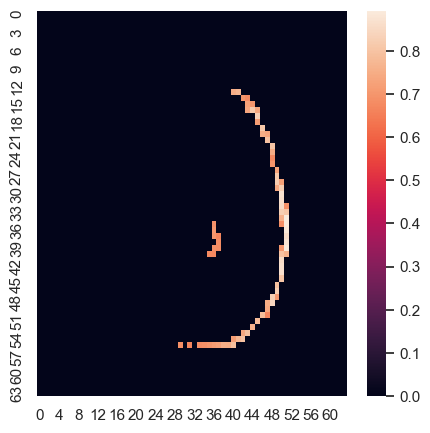

In [154]:
#y_true_np = np.array([i.numpy() for i in decollate_batch(y_true,detach=False)])
#prior_quantile = np.quantile(y_true_np, 0.9)
#print("Prior quantile:",prior_quantile)
#y_stat_test = np.copy(y_stat)
#y_stat_test[y_stat_test < prior_quantile] = 0

sns.heatmap(y_stat_test[0][0], annot=False)

In [45]:
loss_function = nn.L1Loss()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEnc()
model.load_state_dict(torch.load('ae_model.pth'))

TypeError: super(type, obj): obj must be an instance or subtype of type

min tensor(7.4506e-09) max tensor(1476.6730)
7.450580596923828e-09 1476.6729736328125
0 1.0 0.1
Trying 0,0.0
Trying 1,0.1
Trying 2,0.2
Trying 3,0.30000000000000004
Trying 4,0.4
0.2 0.4 0.01
Trying 0,0.2
Trying 1,0.21000000000000002
Trying 2,0.22
Trying 3,0.23
Trying 4,0.24000000000000002
Trying 5,0.25
Trying 6,0.26
Trying 7,0.27
Trying 8,0.28
Trying 9,0.29000000000000004
Trying 10,0.30000000000000004
0.28 0.30000000000000004 0.001
Trying 0,0.28
Trying 1,0.281
Trying 2,0.28200000000000003
Trying 3,0.28300000000000003
Trying 4,0.28400000000000003
0.28200000000000003 0.28400000000000003 0.0001
Trying 0,0.28200000000000003
Trying 1,0.2821
Trying 2,0.2822
Trying 3,0.28230000000000005
Trying 4,0.28240000000000004
Trying 5,0.28250000000000003
0.28230000000000005 0.28250000000000003 1e-05
Trying 0,0.28230000000000005
Trying 1,0.28231000000000006
Trying 2,0.28232000000000007
0.28230000000000005 0.28232000000000007 1e-06
Trying 0,0.28230000000000005
Trying 1,0.282301
Trying 2,0.28230200000000005

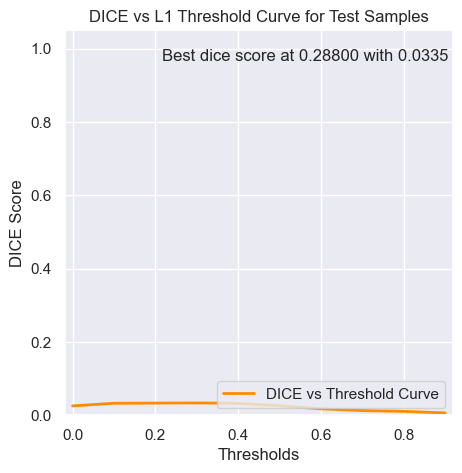

Computing AUROC:


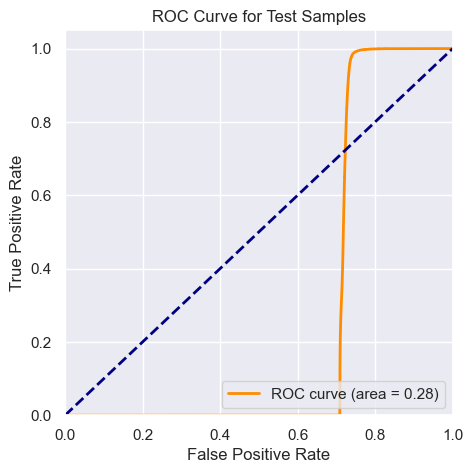

Computing AUPRC:


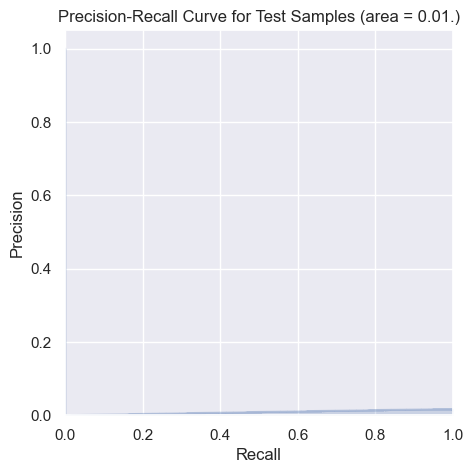

In [183]:
print("min",torch.min(y_stat),"max",torch.max(y_stat))
diff_auc,diff_auprc,diceScore,diceThreshold = metrics(y_stat,y_mask_np,"Test","test")

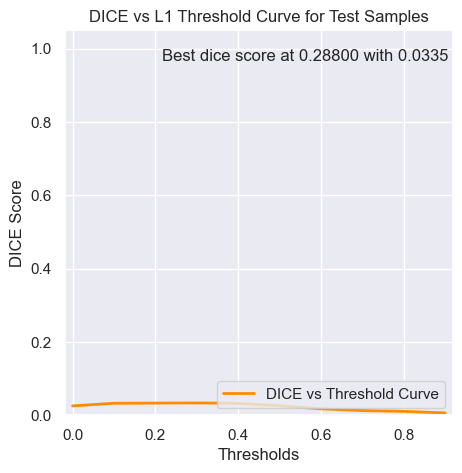

Computing AUROC:


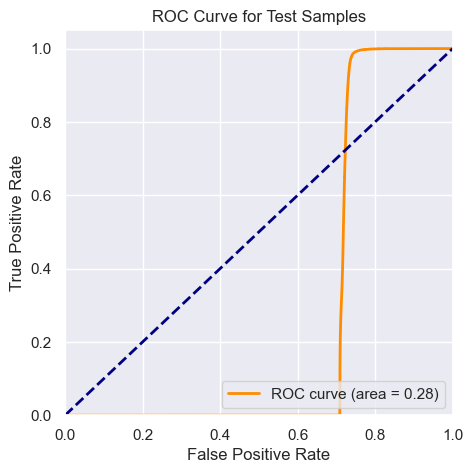

Computing AUPRC:


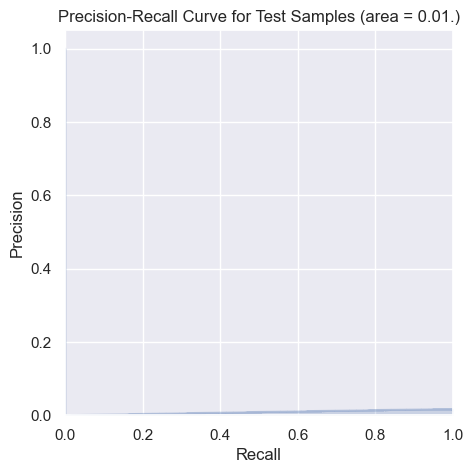


L1 reconstruction error mean: 30.0772 
AUROC: 0.2810 
AUPRC: 0.0089 
DICE score: 0.0335 
Threshold: 0.2880


In [163]:
model.eval()
with torch.no_grad():
    loss_values, y_pred,y_mask,y_true = score(model,test_loader,loss_function)
    
    #y_stat = score_function(y_pred,y_true)
    y_stat = torch.abs(y_true-y_pred)


    y_mask_np = np.array([i.numpy() for i in decollate_batch(y_mask, detach=False)])
    #y_true_np = np.array([i.numpy() for i in decollate_batch(y_true,detach=False)])
    #y_pred_np = np.array([i.numpy() for i in decollate_batch(y_pred)])

    reconstruction_err = np.sum(loss_values)
    avg_reconstruction_err = np.mean(loss_values)
    

    #print(np.unique(y_stat),np.unique(y_mask_np))
    #print("min",torch.min(y_stat),"max",torch.max(y_stat))
    diff_auc,diff_auprc,diceScore,diceThreshold = metrics(y_stat,y_mask_np,"Test","test")

    print(
        f"\nL1 reconstruction error mean: {avg_reconstruction_err:.4f}",
        f"\nAUROC: {diff_auc:.4f}",
        f"\nAUPRC: {diff_auprc:.4f}",
        f"\nDICE score: {diceScore:.4f}",
        f"\nThreshold: {diceThreshold:.4f}",
            )

(6895,) (6895,)
computing dice...


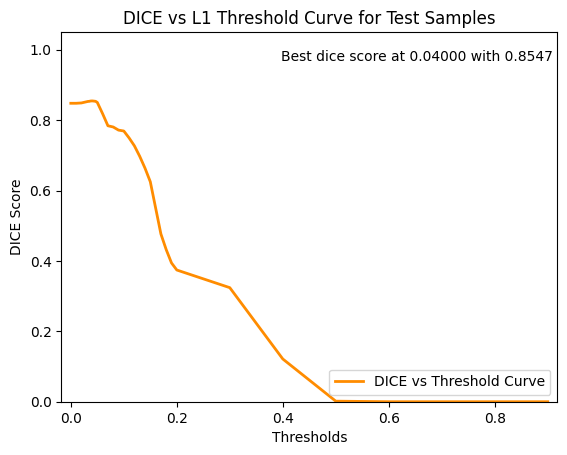

Computing AUROC:


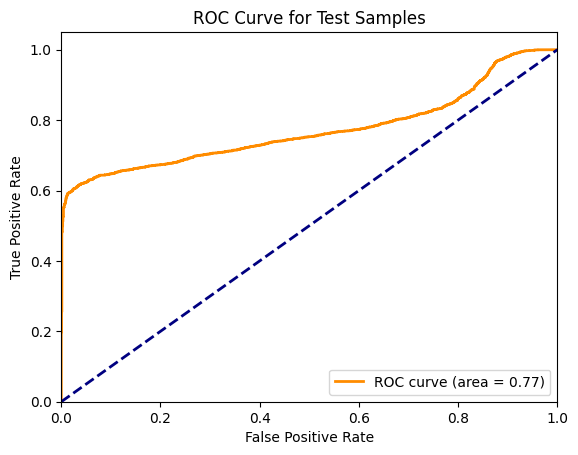

Computing AUPRC:


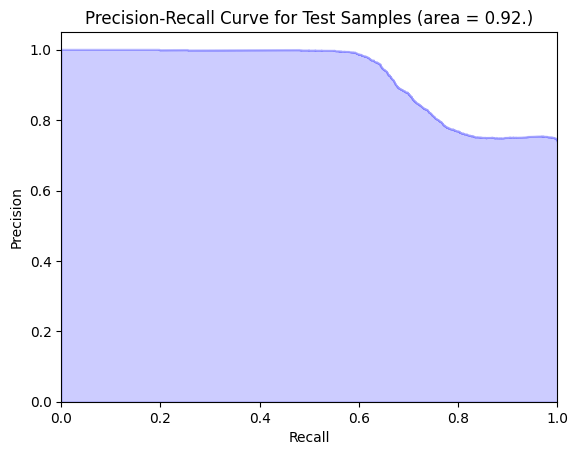

L1 reconstruction error mean: 0.1495 
AUROC: 0.7722 
AUPRC: 0.9248 
DICE score: 0.8547 
Threshold: 0.0400


In [88]:
best_metric = None
test_loss_values = []
model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y_mask = torch.tensor([], dtype=torch.long, device=device)
    y_true = torch.tensor([], dtype=torch.long, device=device)
    val_classes = []
    val_loss_values = []
    #i=0
    for val_data, ground_truths,classification in test_loader:
        val_images = val_data.to(device)
        y_pred = torch.cat([y_pred, model(val_images)], dim=0)
        y_true = torch.cat([y_true, val_images], dim=0)
        y_mask = torch.cat([y_mask, ground_truths], dim=0)
        loss = loss_function(y_pred, y_true)
        val_classes.extend(classification)
        val_loss_values.append(loss.item())
        #print(f"Iter {i+1}:")
        #i+=1
        #if i==3:
        #    break
    y_mask_np = np.array([i.numpy() for i in decollate_batch(y_mask, detach=False)])
    y_true_np = np.array([i.numpy() for i in decollate_batch(y_true,detach=False)])
    y_pred_np = np.array([i.numpy() for i in decollate_batch(y_pred)])

    reconstruction_err = np.sum(val_loss_values)
    avg_reconstruction_err = np.mean(val_loss_values)
    
    img_losses = np.array([loss_function(p,t).item() for p,t in zip(y_pred,y_true)])
    val_classes = np.array(val_classes)
    print(img_losses.shape,val_classes.shape)
    
    folder = "images"
    if not os.path.exists(folder):
        os.mkdir(folder)
    predlabels,diceScore,diceThreshold = compute_dice_curve_recursive(
        img_losses,val_classes,
        plottitle="DICE vs L1 Threshold Curve for Test Samples",
        filename=os.path.join(folder, f'dicePC_test.png'),
        granularity=10
    )


    print("Computing AUROC:")
    diff_auc, _fpr, _tpr, _threshs = compute_roc(img_losses.flatten(), val_classes.astype(bool).flatten(),
                                                                    plottitle="ROC Curve for Test Samples",
                                                                    filename=os.path.join(folder, f'rocPC_test.png'))

    print("Computing AUPRC:")
    diff_auprc, _precisions, _recalls, _threshs = compute_prc(
        img_losses.flatten(),
        val_classes.astype(bool).flatten(),
        plottitle="Precision-Recall Curve for Test Samples",
        filename=os.path.join(folder, f'prcPC_test.png')
    )

    del y_mask_np,y_true_np,y_pred_np
    print(
        f"L1 reconstruction error mean: {avg_reconstruction_err:.4f}",
        f"\nAUROC: {diff_auc:.4f}",
        f"\nAUPRC: {diff_auprc:.4f}",
        f"\nDICE score: {diceScore:.4f}",
        f"\nThreshold: {diceThreshold:.4f}",
    )


In [467]:
h=64
stride=1
padding=0
dilation=1
kernel_size=5
output_padding=0

print((h-1)*stride-2*padding+dilation*(kernel_size-1)+output_padding+1)
print(((h+2*padding-dilation*(kernel_size-1)-1)/(stride))+1)

68
